In [1]:
import sys

In [2]:
print(sys.version)

3.13.5+ (heads/3.13:ad1b0c9, Jun 27 2025, 17:26:25) [Clang 17.0.0 (clang-1700.0.13.3)]


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [6]:
import sqlite3 

In [7]:
conn = sqlite3.connect('/Users/rishidave/Documents/course-demand-predictor-1b/class_space.db')
df = pd.read_sql_query("SELECT * FROM course_data_flattened", conn)
conn.close()

In [8]:
filtered_df = df[(df['subject'] == 'CS') & (df['meeting_meetingTypeDescription'] == 'Lecture')].copy()
if filtered_df.empty:
    print("No data matches the filtering criteria (subject = 'CS' and meeting_meetingTypeDescription = 'Lecture'). Cannot proceed with modeling.")
else:
    # Calculate 'total_enrollment' as sum of 'enrollment' and 'waitCount'
    filtered_df['total_enrollment'] = filtered_df['enrollment'] + filtered_df['waitCount']

    cs_course_enrollment = filtered_df.groupby(['quarter', 'year', 'subjectCourse']).agg(
        total_enrollment=('total_enrollment', 'sum'),
        maximumEnrollment=('maximumEnrollment', 'sum')
    ).reset_index()
    # --- 4. Define Target Variable (Y) and Features (X) ---
    # Target variable: maximumEnrollment (seats required)
    Y = cs_course_enrollment['maximumEnrollment']

    # Selected features based on user's request, now with 'total_enrollment'
    selected_features = [
        'subjectCourse',
        'total_enrollment',
        'year',
        'quarter',
    ]
    X = cs_course_enrollment[selected_features]



In [9]:
categorical_features_grouped = ['subjectCourse']
numerical_features_grouped = [
    'total_enrollment',
    'year',
    'quarter'
]

# Impute missing numerical values (if any)
for col in numerical_features_grouped:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Handle categorical features: One-Hot Encoding
for col in categorical_features_grouped:
    X[col] = X[col].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_grouped),
        ('num', 'passthrough', numerical_features_grouped)
    ],
    remainder='drop' # Drop any columns not specified
)

/var/folders/7x/__pyq_6924g50048lw2v9z6w0000gn/T/ipykernel_62553/3506295869.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)


In [10]:
X_processed = preprocessor.fit_transform(X)

feature_names = preprocessor.get_feature_names_out()
if isinstance(X_processed, np.ndarray):
    X_final = pd.DataFrame(X_processed, columns = feature_names, index = X.index)
else:
    X_final = pd.DataFrame.sparse.from_spmatrix(X_processed, columns=feature_names, index = X.index)

print("Shape of processed data (grouped):", X_final.shape)
print("\nFirst 5 rows of processed data (grouped):")
print(X_final)


Shape of processed data (grouped): (1018, 107)

First 5 rows of processed data (grouped):
      cat__subjectCourse_CS005  cat__subjectCourse_CS006  \
0                          1.0                         0   
1                            0                       1.0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
1013                         0                         0   
1014                         0                         0   
1015                         0                         0   
1016                         0                         0   
1017                         0                         0   

      cat__subjectCourse_CS008  cat__subjectCourse_CS009A  \
0                            0                          0   
1                            0                          0   
2     

In [11]:
cs_enrollment_sorted = cs_course_enrollment.sort_values(by= ['year', 'quarter'])
X_sorted = X_final.loc[cs_enrollment_sorted.index]
Y_sorted = Y.loc[cs_enrollment_sorted.index]

cs_enrollment_sorted['term_identifier'] = cs_enrollment_sorted['year'].astype(str) + cs_enrollment_sorted['quarter'].astype(str).str.zfill(2)
unique_terms = sorted(cs_enrollment_sorted['term_identifier'].unique())

if len(unique_terms) < 2:
        print("Not enough unique terms to perform a time-based split on grouped data. Need at least two distinct quarters.")
        X_train, X_test, y_train, y_test = train_test_split(X_sorted, Y_sorted, test_size=0.2, random_state=42)
        print(f"Using standard train_test_split. Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")
else:
    test_terms = unique_terms[len(unique_terms) - 4: len(unique_terms)]
    train_terms = unique_terms[:-4]
    train_indices = cs_enrollment_sorted[cs_enrollment_sorted['term_identifier'].isin(train_terms)].index
    test_indices = cs_enrollment_sorted[cs_enrollment_sorted['term_identifier'].isin(test_terms)].index

    X_train = X_sorted.loc[train_indices]
    y_train = Y_sorted.loc[train_indices]
    X_test = X_sorted.loc[test_indices]
    y_test = Y_sorted.loc[test_indices]

    print(f"Training on terms (grouped data): {train_terms}")
    print(f"Testing on term (grouped data): {test_terms}")
    print(f"Training data shape (grouped): {X_train.shape}")
    print(f"Testing data shape (grouped): {X_test.shape}")

Training on terms (grouped data): ['201801', '201802', '201803', '201804', '201901', '201902', '201903', '201904', '202001', '202002', '202003', '202004', '202101', '202102', '202103', '202104', '202201', '202202', '202203', '202204', '202301', '202302', '202303', '202304']
Testing on term (grouped data): ['202401', '202402', '202403', '202404']
Training data shape (grouped): (859, 107)
Testing data shape (grouped): (159, 107)


In [12]:
pip freeze | grep -E "pandas|scikit-learn|xgboost"


pandas==2.3.1
scikit-learn==1.7.1
xgboost==3.0.2
Note: you may need to restart the kernel to use updated packages.


In [28]:


if not X_train.empty and not X_test.empty:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    predictions[predictions < 0] = 0
else:
    print("Training or testing data (grouped) is empty after splitting. Model training skipped.")


/Users/rishidave/Documents/course-demand-predictor-1b/venv/lib/python3.13/site-packages/xgboost/data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")
/Users/rishidave/Documents/course-demand-predictor-1b/venv/lib/python3.13/site-packages/xgboost/data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


In [14]:
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"\nMean Absolute Error (MAE) for grouped data: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) for grouped data: {rmse:.2f}")
print(f"R-squared (R2) for grouped data: {r2:.2f}")

results = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print("\nSample of Actual vs. Predicted values (grouped data):")
print(results )



Mean Absolute Error (MAE) for grouped data: 16.93
Root Mean Squared Error (RMSE) for grouped data: 23.90
R-squared (R2) for grouped data: 0.96

Sample of Actual vs. Predicted values (grouped data):
      Actual   Predicted
244      302  300.497009
245      271  308.975128
246      840  823.288391
247      140  154.279877
248       60   66.405716
...      ...         ...
1013     145  110.357574
1014      84   78.072350
1015     115  113.601761
1016     100  107.926895
1017     100   57.401672

[159 rows x 2 columns]


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

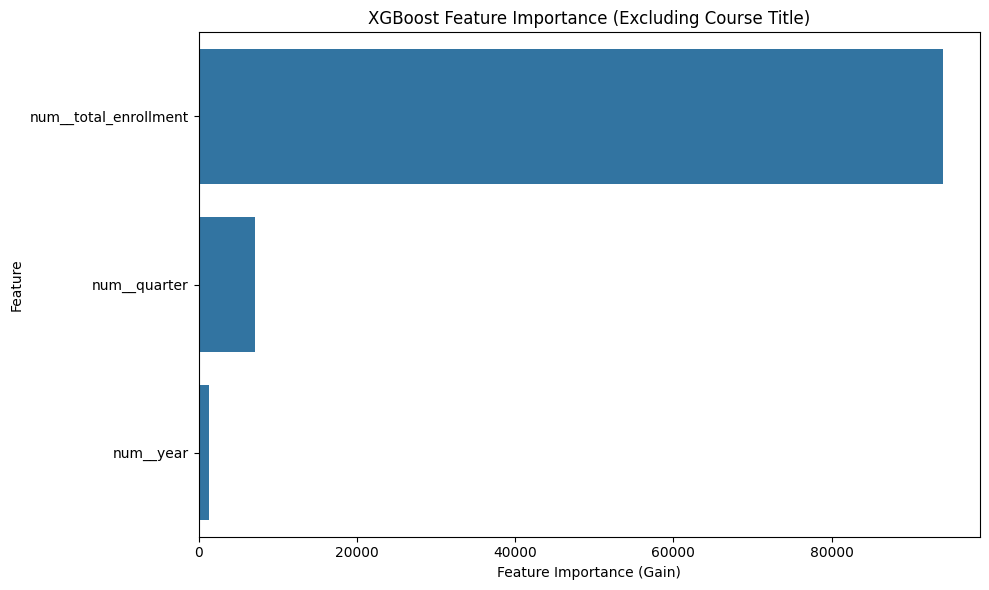


Top 10 Feature Importances (Excluding Course Title):
num__total_enrollment: 94040.74
num__quarter: 7091.98
num__year: 1265.46


In [16]:
feature_importances = model.get_booster().get_score(importance_type='gain')

# Filter out features related to 'courseTitle'
filtered_importances = {
    feature: score for feature, score in feature_importances.items()
    if not feature.startswith('cat__subjectCourse_') # Assuming 'cat__courseTitle_' prefix from OneHotEncoder
}

# Create a DataFrame for plotting and sorting
importance_df = pd.DataFrame(filtered_importances.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the filtered feature importance
plt.figure(figsize=(10, max(6, len(importance_df) * 0.3))) # Adjust figure size dynamically
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance (Excluding Course Title)')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print Top N filtered Feature Importances
print("\nTop 10 Feature Importances (Excluding Course Title):")
for index, row in importance_df.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.2f}")


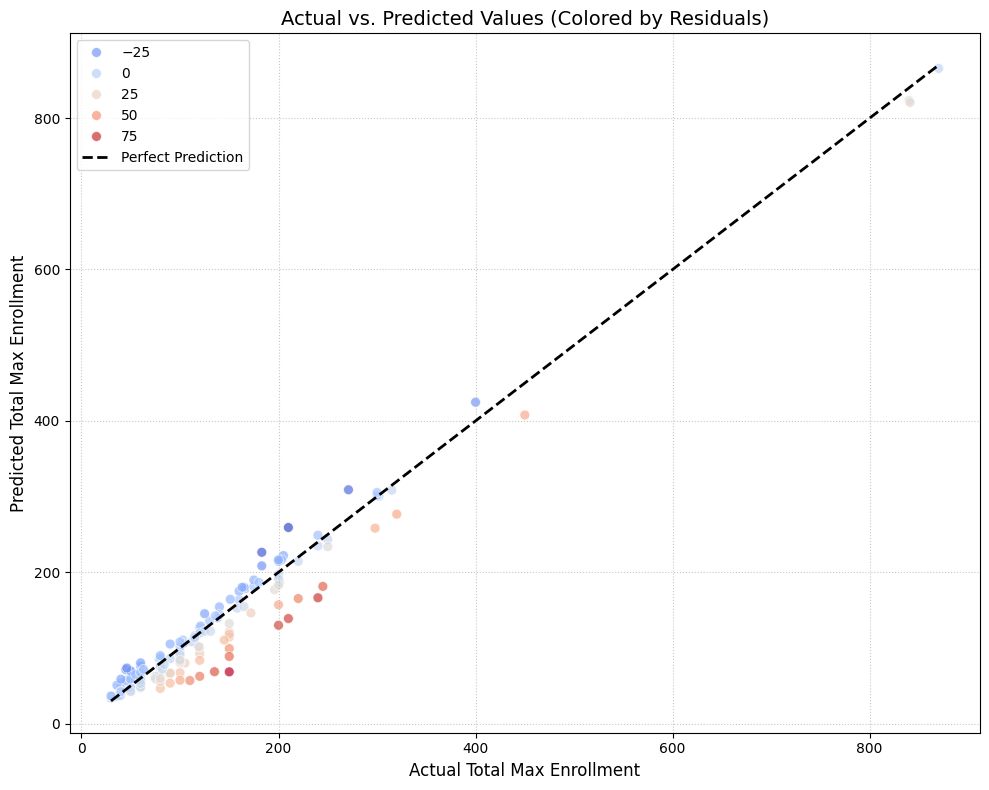

In [17]:
residuals = y_test - predictions

plt.figure(figsize=(10, 8)) # Make the figure slightly larger

# Scatter plot:
# x=Actual values, y=Predicted values
# hue=residuals to color points based on prediction error
# cmap='coolwarm' or 'RdYlGn_r' are good diverging colormaps for errors
# alpha=0.6 for transparency if points overlap
scatter = sns.scatterplot(x=y_test, y=predictions, hue=residuals, palette='coolwarm', alpha=0.7, s=50) # s for marker size

# Add the diagonal line (perfect prediction line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction') # 'k--' for black dashed line

plt.xlabel('Actual Total Max Enrollment', fontsize=12)
plt.ylabel('Predicted Total Max Enrollment', fontsize=12)
plt.title('Actual vs. Predicted Values (Colored by Residuals)', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7) # Add a subtle grid
plt.legend() # Show legend for the perfect prediction line and color bar

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


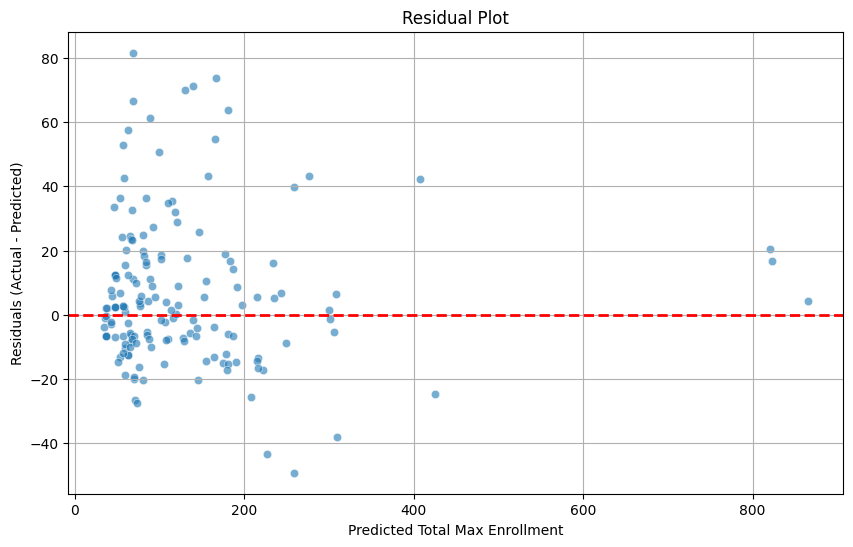

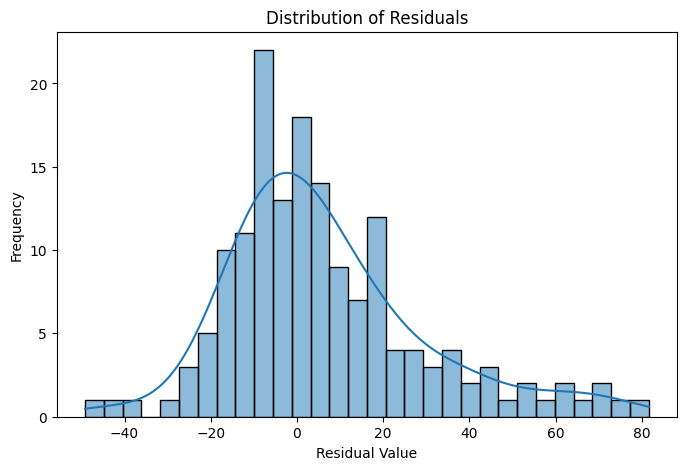

In [18]:

residuals = y_test - predictions

plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2) # Zero line
plt.xlabel('Predicted Total Max Enrollment')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

# You can also look at the distribution of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


In [19]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


/Users/rishidave/Documents/course-demand-predictor-1b/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/rishidave/Documents/course-demand-predictor-1b/venv/lib/python3.13/site-packages/xgboost/data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


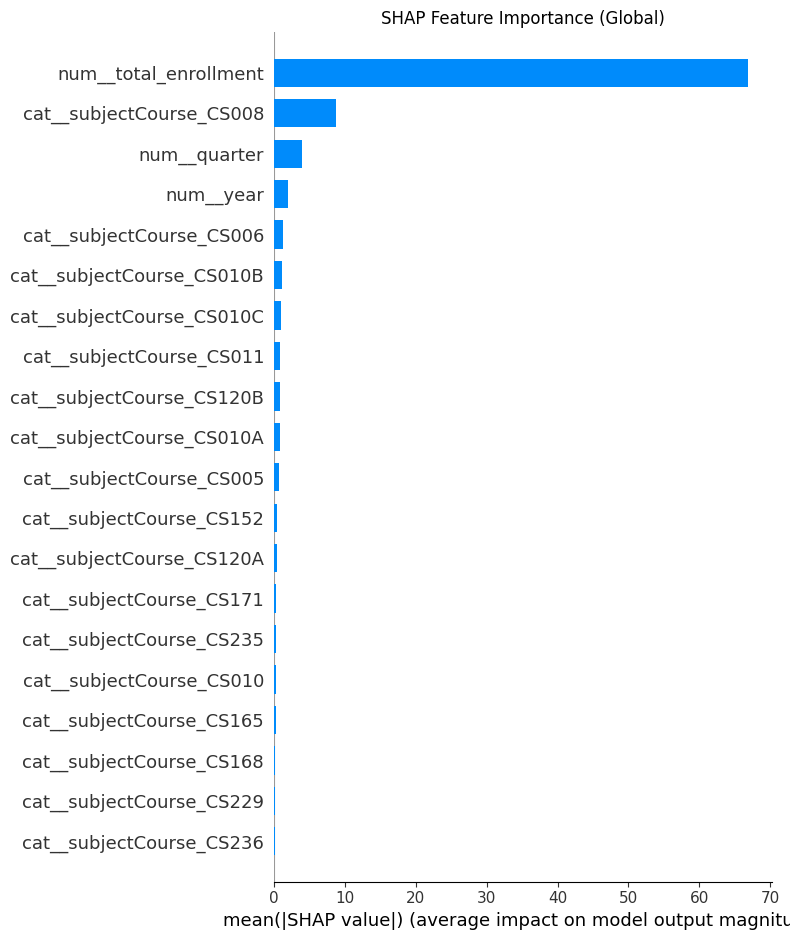

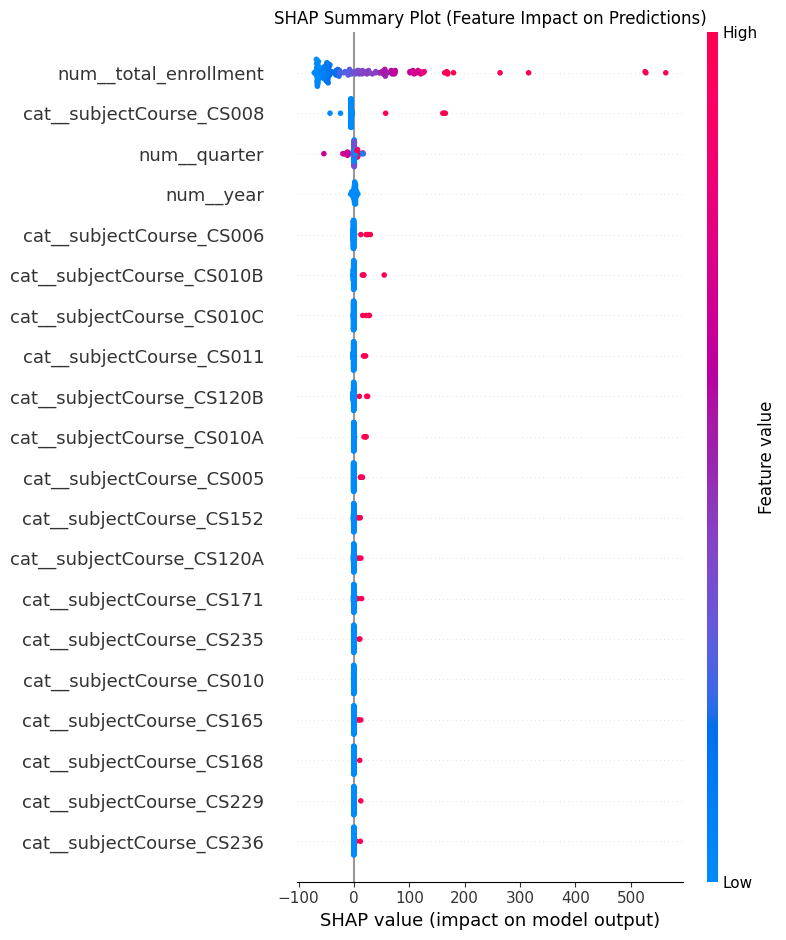

In [20]:
import shap
# It's good practice to use a smaller sample for SHAP for large datasets
# For demonstration, let's use the entire X_test or a sample
sample_X_test = X_test # For demonstration, using full X_test. Consider X_test.sample(n=500, random_state=42) for large datasets.

# Create a SHAP Explainer object
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(sample_X_test)

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, sample_X_test, plot_type="bar", show=False) # Bar plot for global importance
plt.title('SHAP Feature Importance (Global)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, sample_X_test, show=False) # Beeswarm plot for individual impact
plt.title('SHAP Summary Plot (Feature Impact on Predictions)')
plt.tight_layout()
plt.show()


Generating Historical Train vs Test Prediction and Actual Values for a Single Course...


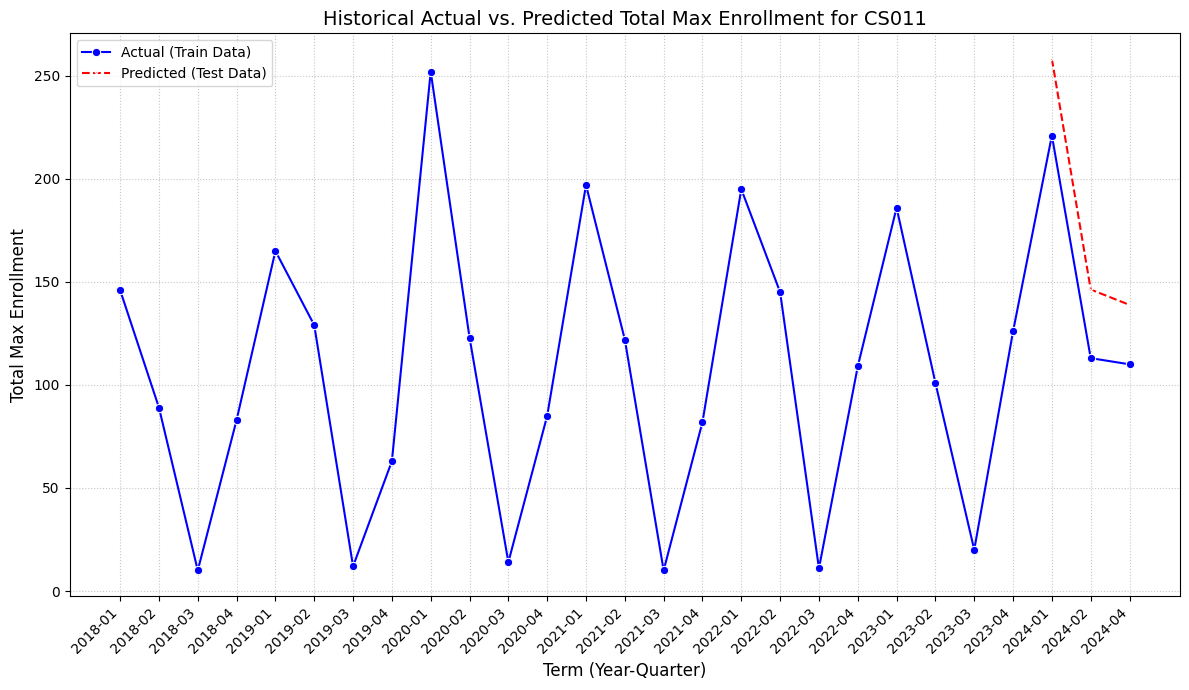

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Ensure numpy is imported if not already


# --- Historical Train vs Test Prediction and Actual Values for a Single Course ---
print("\nGenerating Historical Train vs Test Prediction and Actual Values for a Single Course...")

# Choose a specific course to visualize.
# Ensure this course exists in your filtered and aggregated data for both train and test years.
target_course = 'CS011' # <--- IMPORTANT: Change this to the 'subjectCourse' you want to visualize
test_year = 2024

# Filter the aggregated_course_data for the chosen course
# This DataFrame holds the actual historical values for the course across all terms
course_data_agg = cs_course_enrollment[cs_course_enrollment['subjectCourse'] == target_course].copy()

if course_data_agg.empty:
    print(f"No aggregated data found for course '{target_course}'. Please ensure it's a valid 'CS' Lecture course in your data.")
else:
    # Create a time identifier for consistent x-axis plotting (e.g., '2023-10', '2024-40')
    course_data_agg['time_id'] = course_data_agg['year'].astype(str) + '-' + course_data_agg['quarter'].astype(str).str.zfill(2)
    course_data_agg = course_data_agg.sort_values(by=['year', 'quarter'])

    # Prepare a DataFrame for plotting, including actual values and a placeholder for predictions
    plot_df_historical = course_data_agg[['time_id', 'year', 'total_enrollment']].copy()
    plot_df_historical = plot_df_historical.rename(columns={'total_enrollment': 'Actual_Value'})
    plot_df_historical['Predicted_Value'] = np.nan # Initialize predicted column with NaNs

    # --- Correctly map predictions from `predictions` (NumPy array) back to `plot_df_historical` ---
    # `predictions` array is aligned with `X_test` (the processed features used for prediction).
    # We need to find the rows in `X_test` that correspond to our `target_course`
    # and then map their predictions back to the `plot_df_historical`.
    temp_test_predictions = X_test.copy()
    temp_test_predictions['Predicted'] = predictions # Add predictions to temp X_test

    # 1. Find the one-hot encoded column name for the target_course
    # This relies on `preprocessor` and `categorical_features_grouped` from your main script.
    target_course_ohe_col = None
    for name in feature_names:
        if f'cat__subjectCourse_{target_course}' in name:
            target_course_ohe_col = name
            break

    if target_course_ohe_col is None or target_course_ohe_col not in temp_test_predictions.columns:
        print(f"Warning: One-hot encoded column for '{target_course}' not found in X_test. Predictions for this course may not be available.")
    else:
        # Filter temp_test_predictions for the target course and test year
        course_test_predictions = temp_test_predictions[
            (temp_test_predictions[target_course_ohe_col] == 1.0) &
            (temp_test_predictions['num__year'] == test_year) # Ensure it's for the test year
        ].copy() # Use .copy() to avoid SettingWithCopyWarning

        if not course_test_predictions.empty:
            # Create a time_id for these filtered predictions
            course_test_predictions['time_id'] = course_data_agg['year'].astype(str) + '-' + course_data_agg['quarter'].astype(str).str.zfill(2)

            # Map the predicted values to the plot_df_historical
            plot_df_historical.set_index('time_id', inplace=True)
            for time_id_val in course_test_predictions['time_id'].unique():
                predicted_val = course_test_predictions[course_test_predictions['time_id'] == time_id_val]['Predicted'].iloc[0]
                predicted_year = course_test_predictions[course_test_predictions['time_id'] == time_id_val]['num__year'].iloc[0]
                plot_df_historical.loc[time_id_val, 'Predicted_Value'] = predicted_val
                plot_df_historical.loc[time_id_val, 'year'] = predicted_year
            plot_df_historical.reset_index(inplace=True) # Reset index for lineplot
        else:
            print(f"No predictions found for course '{target_course}' in the test set ({test_year}).")


    # --- Plotting ---
    plt.figure(figsize=(12, 7))

    # Plot Actual values for training data (years prior to test_year)
    train_plot_df = plot_df_historical
    if not train_plot_df.empty:
        sns.lineplot(x='time_id', y='Actual_Value', data=train_plot_df, marker='o', label='Actual (Train Data)', color='blue')
    # Plot Predicted values for test data (year == test_year, drop NaNs)
    test_predicted_plot_df = plot_df_historical[plot_df_historical['year'] == test_year].dropna(subset=['Predicted_Value'])
    if not test_predicted_plot_df.empty:
        sns.lineplot(x='time_id', y='Predicted_Value', data=test_predicted_plot_df, marker='x', label='Predicted (Test Data)', color='red', linestyle='--')
    else:
        print(f"Predicted values for '{target_course}' in test year {test_year} are all NaN or empty after mapping. The predicted line will not appear.")


    plt.xlabel('Term (Year-Quarter)', fontsize=12)
    plt.ylabel('Total Max Enrollment', fontsize=12)
    plt.title(f'Historical Actual vs. Predicted Total Max Enrollment for {target_course}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'historical_plot_{target_course}.png')
    plt.show()


In [53]:
import pandas as pd
import numpy as np

# Assuming y_test and predictions are available from your model evaluation.

# 1. Calculate residuals
residuals = y_test - predictions

# 2. Create a DataFrame to hold course details and their residuals
# y_test's index corresponds to the original index in aggregated_course_data
# We'll use this index to pull the subjectCourse, year, and quarter.
residual_analysis_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': predictions,
    'Residual': residuals
})

# Merge with aggregated_course_data to get course details
# Ensure indices align.
residual_analysis_df = residual_analysis_df.merge(
    cs_course_enrollment[['subjectCourse', 'year', 'quarter']],
    left_index=True,
    right_index=True,
    how='left'
)

# Create a combined term identifier for easier viewing
residual_analysis_df['term_id'] = residual_analysis_df['year'].astype(str) + '-' + \
                                  residual_analysis_df['quarter'].astype(str).str.zfill(2)

# 3. Sort by the absolute value of residuals in descending order
residual_analysis_df['Abs_Residual'] = np.abs(residual_analysis_df['Residual'])
sorted_residuals = residual_analysis_df.sort_values(by='Abs_Residual', ascending=False)

# 4. Display the top N courses with the biggest residuals
print("\n--- Courses with the Biggest Residuals (Largest Errors) ---")
print("These are courses where the model's prediction deviated most from the actual value.")
print("(Positive residual: Actual > Predicted; Negative residual: Actual < Predicted)")
print(sorted_residuals[['subjectCourse', 'term_id', 'Actual_Value', 'Predicted_Value', 'Residual', 'Abs_Residual']].head(10))

# Optionally, you can also look at specific cases:
# Courses where model significantly underestimated (large positive residual)
print("\n--- Top Underpredicted Courses (Actual >> Predicted) ---")
print(sorted_residuals[sorted_residuals['Residual'] > 0][['subjectCourse', 'term_id', 'Actual_Value', 'Predicted_Value', 'Residual']].head(5))

# Courses where model significantly overestimated (large negative residual)
print("\n--- Top Overpredicted Courses (Actual << Predicted) ---")
print(sorted_residuals[sorted_residuals['Residual'] < 0][['subjectCourse', 'term_id', 'Actual_Value', 'Predicted_Value', 'Residual']].head(5))


--- Courses with the Biggest Residuals (Largest Errors) ---
These are courses where the model's prediction deviated most from the actual value.
(Positive residual: Actual > Predicted; Negative residual: Actual < Predicted)
     subjectCourse  term_id  Actual_Value  Predicted_Value   Residual  \
986          CS150  2024-04           150        68.436531  81.563469   
288          CS242  2024-01           240       166.298996  73.701004   
976          CS011  2024-04           210       138.844742  71.155258   
980          CS111  2024-04           200       129.936859  70.063141   
286          CS236  2024-01           135        68.606735  66.393265   
259         CS120A  2024-01           245       181.324646  63.675354   
996          CS171  2024-04           150        88.807686  61.192314   
572          CS205  2024-02           120        62.550190  57.449810   
255          CS100  2024-01           220       165.308182  54.691818   
1002         CS202  2024-04           110     